In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
from os.path import join as jp

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import seaborn as sns

from dpipe.io import load_json

from iw.metric import exp2prc_df, get_prc, get_size_df
from iw.utils import np_sigmoid, get_iw_dir_name

In [3]:
def f_luna(d):
    if d < 8:
        return 'small'
    else:
        return 'large'
    
    
def f_met(d):
    if d < 5:
        return 'small'
    else:
        return 'large'
    
    
def f_lits(d):
    if d < 12:
        return 'small'
    else:
        return 'large'
    
    
def path2title_f(exp_path):
    if 'luna' in exp_path:
        return 'LUNA16', f_luna
    elif 'met' in exp_path:
        return 'Metastases', f_met
    elif 'lits' in exp_path:
        return 'LiTS', f_lits


# ===============================================================================================================

def bootstrap_prc_df(df, n_ids, thresholds, dice_th=0, with_logits=False, n_iter=50, sample_fraction=0.8, seed=42):
    ids = np.unique(df['id'])
    n_samples = int(len(ids) * sample_fraction)
    rs = np.random.RandomState(seed=seed)
    
    prcs = []
    for n in range(n_iter):
        rs.shuffle(ids)
        iter_ids = ids[:n_samples]
        iter_df = df[np.array([True if _id in iter_ids else False for _id in df['id']])]
        
        if with_logits:
            prc_iter = get_prc(iter_df, thresholds=thresholds, dice_th=dice_th,
                                   self_stat='self_logit', hit_stat='hit_logit')
        else:
            prc_iter = get_prc(iter_df, thresholds=thresholds, dice_th=dice_th)
            
        prc_iter['avgFP'] = np.array(prc_iter['totalFP']) / n_ids
        
        prcs.append(prc_iter)
        
    return prcs


def average_prcs(prcs, axis, max_fp=6):
    x_points = np.linspace(0, max_fp, max_fp*100+1)
    ys = []
    for prc in prcs:
        ys.append(np.interp(x_points, prc[axis[0]][::-1], prc[axis[1]][::-1]))
        
    ys = np.array(ys)
    mean_y = np.mean(ys, axis=0)
    std_y = np.std(ys, axis=0)
    
    return x_points, mean_y, std_y

# ================================================================================================================


def exp2dice(exp_path):
    exp_name = exp_path.split('/')[-1]
    if len(exp_name) == 0:
        exp_name = exp_path.split('/')[-2]
        
    dices_path = jp(exp_path, 'experiment_0', 'test_metrics', 'dice.json')
    dices = list(load_json(dices_path).values())
    
    print(exp_name, '(Dice Score):', f'{np.mean(dices):.2f}', '+-', f'{np.std(dices):.2f}')
    
    
def exp2th_dice(exp_path, th):
    exp_name = exp_path.split('/')[-1]
    if len(exp_name) == 0:
        exp_name = exp_path.split('/')[-2]
    
    cfg = read_config(jp(exp_path, 'resources.config'))
    test_ids = load_json(jp(exp_path, 'experiment_0/test_ids.json'))
    
    dices = []
    for _id in test_ids:
        y = cfg.load_y(_id)[0] > 0.5
        pred = load_pred(_id, jp(exp_path, 'experiment_0/test_predictions'))[0] > th
        dices.append(dice_score(pred, y))
    
    print(exp_name, '(thresh Dice):', f'{np.mean(dices):.2f}', '+-', f'{np.std(dices):.2f}')
    
    
def prc2luna_metric(prc, axis, max_fp, luna_orig=False):
    # luna metric
    assert axis[0] == 'avgFP' and axis[1] == 'recall'
    
    prc0, prc1 = list(prc[axis[0]]), list(prc[axis[1]])
    prc0.append(0)
    prc1.append(0)
    if luna_orig:
        x_points = [0.125, 0.25, 0.5, 1, 2, 4, 8]
    else:
        x_points = np.linspace(0, max_fp, max_fp*100+1)
        
    luna_metric = np.mean(np.interp(x_points, prc0[::-1], prc1[::-1]))
        
    return luna_metric
        
        
# ================================================================================================================


def plot_prc(i, axs, exp_path, axis, loc, color, with_metric=False, with_logits=True, dice_th=0):
    label = exp_path.split('/')[-1]
    if len(label) == 0:
        label = exp_path.split('/')[-2]
        
    axis2label = {'precision': 'Precision', 'recall': 'Recall', 'avgFP': 'Average FP',
                  'avg_dice': 'Average Local Dice'}
    title, f_size = path2title_f(exp_path)
    
    n_val = len([exp_n for exp_n in os.listdir(exp_path) if 'experiment_' in exp_n])
    
    df = exp2prc_df(exp_path, n_val=n_val)
    # df['size'] = df['diameter'].apply(f_size)
    df.reset_index(inplace=True, drop=True)
    # df = get_size_df(df, size='small')
    n_ids = len(np.unique(df.id))
    
    
    if with_logits:
        max_logit = np.max(df[(df['self_logit'] > -np.inf) & (df['self_logit'] < np.inf)]['self_logit'])
        thresholds = np.concatenate((np.linspace(-0.1, 10, num=101), np.linspace(10, max_logit+1, num=100)))
        prc = get_prc(df, thresholds=thresholds, dice_th=dice_th, hit_stat='hit_logit', self_stat='self_logit')
    else:
        thresholds = np_sigmoid(np.linspace(0, 10, num=51))
        prc = get_prc(df, thresholds=thresholds)

    prc['avgFP'] = np.array(prc['totalFP']) / n_ids
    
#     cherry_picked_fp = np.min([4, np.max(prc['avgFP'])])
#     print(label, np.max([0.5, np_sigmoid(thresholds[prc['avgFP'] <= cherry_picked_fp][0])]))
    
    prcs = bootstrap_prc_df(df, n_ids, thresholds, dice_th=dice_th, with_logits=with_logits)
    x, y, std_y = average_prcs(prcs, axis, max_fp=np.min([np.max(prc['avgFP']), 6]))
    
    ax = axs
    ax.plot(x, y, color=color, linestyle='-', label=label, linewidth=2)
    ax.fill_between(x, y - std_y, y + std_y, color=color, alpha=0.2)

#     ax.plot(prc[axis[0]], prc[axis[1]], color=color, linestyle='-', label=label, linewidth=3)
#     ax.plot(prc[axis[0]], prc[axis[1]], '.', color=color, ms=7)

    ax.set_title(title, fontsize=22)
    ax.set_xlabel(axis2label[axis[0]], fontsize=24)
    ax.set_ylabel(axis2label[axis[1]], fontsize=24)
    ax.legend(fontsize=16, loc=loc)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
    if with_metric:
        # Dice Score
#         exp2dice(exp_path)
    
        # object Dice Score
        avg_dice, std_dice = prc['avg_dice'][0], prc['std_dice'][0]
        print(label, '(object Dice):', f'{avg_dice:.2f}', '+-', f'{std_dice:.2f}')
    
    
        # avg-std for luna metric:
        max_fp = 5
        luna_metrics, avg_recalls = [], []
        for _prc in prcs:
            luna_metrics.append(prc2luna_metric(_prc, axis, max_fp, luna_orig=True))
            avg_recalls.append(prc2luna_metric(_prc, axis, max_fp))
        print(label, '(luna metric):', f'{np.mean(luna_metrics):.2f}', '+-', f'{np.std(luna_metrics):.2f}')
        print(label, '(avg Recall):', f'{np.mean(avg_recalls):.2f}', '+-', f'{np.std(avg_recalls):.2f}')
        
        print(' ')


def experiments2plot(paths_to_exp, axis=['avgFP', 'recall'], with_metric=False, with_logits=True, dice_th=0):
    linestyles = []
    
    colors = sns.color_palette(palette='colorblind', n_colors=len(paths_to_exp))
    linestyles = ['-'] * len(paths_to_exp)
    loc=4
    
    rows, cols, size = 1, 1, 6
    fig, axs = plt.subplots(rows, cols, figsize=(size * cols + 1, size * rows), dpi=100)
    
    axs.set_xlim((0, 6.1))
    axs.set_ylim((0, 1.02))
    
    axs.set_xticks([0, 1, 2, 3, 4, 5, 6])
    axs.xaxis.set_tick_params(labelsize=20)
    
    axs.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    axs.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9], minor=True)
    axs.yaxis.set_tick_params(labelsize=20)
    
    for i, (path_to_exp, color) in enumerate(zip(tqdm_notebook(paths_to_exp), colors)):
        plot_prc(i, axs, path_to_exp, axis, loc, color,
                 with_metric=with_metric, with_logits=with_logits, dice_th=dice_th)
        
    plt.show()

luna_fl_25 (object Dice): 0.28 +- 0.28
luna_fl_25 (luna metric): 0.11 +- 0.01
luna_fl_25 (avg Recall): 0.13 +- 0.01
 
luna_fl_50 (object Dice): 0.37 +- 0.31
luna_fl_50 (luna metric): 0.22 +- 0.01
luna_fl_50 (avg Recall): 0.26 +- 0.02
 
luna_fl_75 (object Dice): 0.43 +- 0.30
luna_fl_75 (luna metric): 0.22 +- 0.01
luna_fl_75 (avg Recall): 0.27 +- 0.02
 
luna_fl_83 (object Dice): 0.48 +- 0.28
luna_fl_83 (luna metric): 0.22 +- 0.01
luna_fl_83 (avg Recall): 0.26 +- 0.01
 



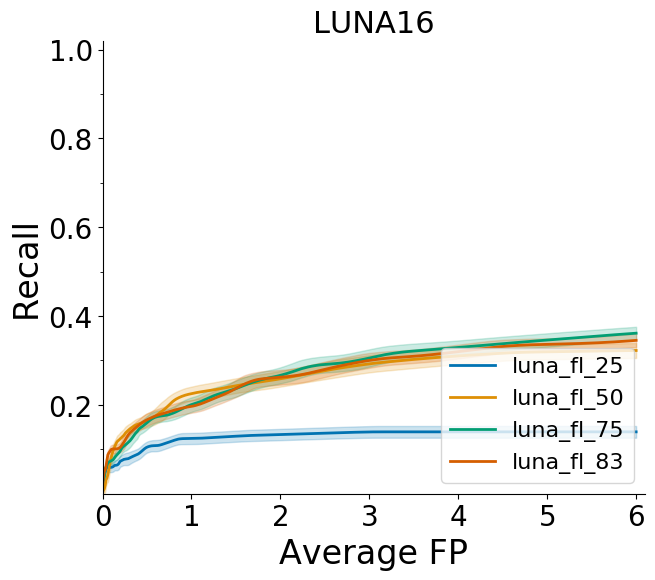

In [4]:
exp_paths = [
    jp(get_iw_dir_name(), '../froc_data/val_focal_loss/luna_fl_25'),
    jp(get_iw_dir_name(), '../froc_data/val_focal_loss/luna_fl_50'),
    jp(get_iw_dir_name(), '../froc_data/val_focal_loss/luna_fl_75'),
    jp(get_iw_dir_name(), '../froc_data/val_focal_loss/luna_fl_83'),
]
experiments2plot(exp_paths, with_metric=True, with_logits=True)